In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### 1. Setup and Imports

In this section, we import all necessary libraries for building and training the autoencoder-based voice conversion model.  
We include core PyTorch modules for deep learning, `torchaudio` for audio handling, and supporting libraries such as `librosa`, `numpy`, and `pandas` for preprocessing and data manipulation.  
Reproducibility is ensured through fixed random seeds, and GPU acceleration is enabled when available.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T

import numpy as np
import pandas as pd
import librosa
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# Set random seeds for reproducibility
def set_seed(seed=42):
    """Ensures reproducible results across runs"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Device configuration - use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### 2. Configuration and Hyperparameters

This section defines a centralized `Config` class that stores all key hyperparameters and paths used throughout the notebook.  
It includes settings for audio preprocessing, model architecture, and training parameters.  
Keeping these configurations in one place makes the workflow easier to maintain and adjust during experimentation.


In [5]:
class Config:
    """Central configuration for all hyperparameters"""
    
    # Audio processing parameters
    sample_rate = 16000  # Standard for speech processing
    n_fft = 1024  # FFT window size
    hop_length = 256  # Number of samples between frames
    win_length = 1024  # Window length for STFT
    n_mels = 80  # Number of mel frequency bins
    
    # Model architecture parameters
    content_dim = 256  # Dimension of content embeddings
    speaker_dim = 256  # Dimension of speaker embeddings
    hidden_dim = 512  # Hidden layer size
    num_layers = 2  # Number of LSTM/GRU layers
    
    # Training parameters - Balanced for reasonable speed and quality
    batch_size = 24  # Good balance between speed and memory
    num_epochs = 15  # REDUCED - faster training, but no enough for actual conversion(min:100)
    learning_rate = 0.0001
    gradient_clip = 1.0  # Prevent exploding gradients
    
    # Data parameters
    max_audio_length = 2.5  # Slightly shorter clips for faster processing
    train_split = 0.8  # 80% training, 20% validation
    
    # Paths (adjust these for your Kaggle setup)
    data_path = "/kaggle/input/english-multispeaker-corpus-for-voice-cloning/VCTK-Corpus/VCTK-Corpus"
    checkpoint_dir = "/kaggle/working/checkpoints"
    
config = Config()

### 3. Dataset Preparation (VCTK Corpus)

The **VCTKDataset** class is a custom PyTorch `Dataset` designed for the [VCTK Corpus](https://datashare.ed.ac.uk/handle/10283/3443), a multi-speaker English speech dataset commonly used for voice conversion and speech synthesis tasks.

Each audio file is:
- Loaded and resampled to the target sampling rate.  
- Converted to mono if needed.  
- Trimmed or zero-padded to a fixed length for batch consistency.  
- Transformed into a **log-scaled mel-spectrogram** representation for model input.

The dataset automatically splits into training and validation subsets according to the defined `train_split` ratio in the configuration.  
The accompanying `get_dataloaders()` function creates efficient PyTorch `DataLoader` objects for both splits, enabling batched and parallelized loading during training.


In [6]:

class VCTKDataset(Dataset):
    """
    Custom dataset for VCTK Corpus
    Loads audio files and extracts mel-spectrograms on-the-fly
    """
    
    def __init__(self, data_path, config, split='train'):
        """
        Args:
            data_path: Path to VCTK corpus
            config: Configuration object
            split: 'train' or 'val'
        """
        self.config = config
        self.data_path = Path(data_path)
        
        # Find all audio files
        self.audio_files = self._get_audio_files()
        
        # Split into train/val
        split_idx = int(len(self.audio_files) * config.train_split)
        if split == 'train':
            self.audio_files = self.audio_files[:split_idx]
        else:
            self.audio_files = self.audio_files[split_idx:]
        
        # Extract unique speakers
        self.speakers = sorted(list(set([f.split('_')[0] for f in self.audio_files])))
        self.speaker_to_idx = {spk: idx for idx, spk in enumerate(self.speakers)}
        
        print(f"{split} set: {len(self.audio_files)} files, {len(self.speakers)} speakers")
        
        # Mel-spectrogram transform
        self.mel_transform = T.MelSpectrogram(
            sample_rate=config.sample_rate,
            n_fft=config.n_fft,
            hop_length=config.hop_length,
            n_mels=config.n_mels
        )
    
    def _get_audio_files(self):
        """Scan directory and collect all .wav files"""
        audio_dir = self.data_path / "wav48" if (self.data_path / "wav48").exists() else self.data_path
        audio_files = []
        
        for speaker_dir in audio_dir.iterdir():
            if speaker_dir.is_dir():
                for audio_file in speaker_dir.glob("*.wav"):
                    # Format: speakerID_audioID.wav
                    audio_files.append(f"{speaker_dir.name}_{audio_file.stem}")
        
        return sorted(audio_files)
    
    def _load_audio(self, file_identifier):
        """Load and preprocess audio file"""
        speaker_id, audio_id = file_identifier.split('_', 1)
        
        # Construct full path
        audio_path = self.data_path / "wav48" / speaker_id / f"{audio_id}.wav"
        if not audio_path.exists():
            audio_path = self.data_path / speaker_id / f"{audio_id}.wav"
        
        # Load audio
        waveform, sr = torchaudio.load(audio_path)
        
        # Resample if necessary
        if sr != self.config.sample_rate:
            resampler = T.Resample(sr, self.config.sample_rate)
            waveform = resampler(waveform)
        
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Trim or pad to fixed length
        max_length = int(self.config.max_audio_length * self.config.sample_rate)
        if waveform.shape[1] > max_length:
            waveform = waveform[:, :max_length]
        else:
            waveform = F.pad(waveform, (0, max_length - waveform.shape[1]))
        
        return waveform
    
    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        """
        Returns:
            mel: Mel-spectrogram (n_mels, time_steps)
            speaker_id: Integer speaker ID
        """
        file_id = self.audio_files[idx]
        speaker_id = file_id.split('_')[0]
        
        # Load audio
        waveform = self._load_audio(file_id)
        
        # Extract mel-spectrogram
        mel = self.mel_transform(waveform)
        mel = torch.log(mel + 1e-9)  # Log scale for better representation
        
        # Remove channel dimension and transpose to (time, mel)
        mel = mel.squeeze(0).transpose(0, 1)
        
        return mel, self.speaker_to_idx[speaker_id]


def get_dataloaders(config):
    """Create train and validation dataloaders"""
    
    train_dataset = VCTKDataset(config.data_path, config, split='train')
    val_dataset = VCTKDataset(config.data_path, config, split='val')
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    return train_loader, val_loader, train_dataset.speakers

### 4. Model Architecture — Content Encoder

The **Content Encoder** module is responsible for extracting *speaker-independent* linguistic or phonetic information from speech.  
It takes log-scaled mel-spectrograms as input and outputs high-level content embeddings.

**Key design choices:**
- A **bidirectional LSTM** captures temporal dependencies in both forward and backward directions, essential for modeling speech context.  
- A **linear projection layer** reduces the dimensionality from the concatenated hidden states to a compact `content_dim` embedding.  
- **Instance normalization** is applied along the feature axis to reduce speaker-related variations, promoting invariance in the learned representation.

**Output:**  
A time-aligned sequence of embeddings `(batch, time, content_dim)` representing content-only features that can later be combined with speaker characteristics in the decoder.


In [7]:
class ContentEncoder(nn.Module):
    """
    Extracts speaker-independent content features from audio
    Uses bidirectional LSTM to capture temporal dependencies
    """
    
    def __init__(self, config):
        super(ContentEncoder, self).__init__()
        
        # Input: mel-spectrogram features
        self.input_dim = config.n_mels
        self.hidden_dim = config.hidden_dim
        self.content_dim = config.content_dim
        
        # Bidirectional LSTM layers
        # These capture long-range dependencies in speech
        self.lstm = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=self.hidden_dim,
            num_layers=config.num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.1 if config.num_layers > 1 else 0
        )
        
        # Project bidirectional output to content dimension
        self.projection = nn.Linear(self.hidden_dim * 2, self.content_dim)
        
        # Instance normalization helps with speaker invariance
        self.norm = nn.InstanceNorm1d(self.content_dim)
    
    def forward(self, mel):
        """
        Args:
            mel: (batch, time, n_mels)
        Returns:
            content: (batch, time, content_dim) - speaker-independent features
        """
        # Pass through LSTM
        lstm_out, _ = self.lstm(mel)  # (batch, time, hidden_dim*2)
        
        # Project to content dimension
        content = self.projection(lstm_out)  # (batch, time, content_dim)
        
        # Normalize to remove speaker characteristics
        content = content.transpose(1, 2)  # (batch, content_dim, time)
        content = self.norm(content)
        content = content.transpose(1, 2)  # (batch, time, content_dim)
        
        return content

### 5. Model Architecture — Speaker Encoder

The **Speaker Encoder** module extracts *speaker-specific* characteristics from mel-spectrograms, producing a compact embedding that represents the speaker’s unique vocal identity.

**Architecture overview:**
- A series of **1D convolutional layers** with batch normalization and ReLU activations capture frequency-dependent timbral features characteristic of each speaker.  
- **Max pooling** progressively reduces temporal resolution, focusing on stable speaker attributes rather than transient content.  
- A **GRU layer** aggregates temporal information into a single representation.  
- A **fully connected projection** maps the aggregated features into a fixed-dimensional `speaker_dim` embedding.

**Output:**  
A fixed-size speaker embedding `(batch, speaker_dim)` that captures consistent speaker identity information across different utterances.


In [8]:
class SpeakerEncoder(nn.Module):
    """
    Extracts speaker embedding from mel-spectrogram
    Uses CNN layers followed by temporal pooling
    """
    
    def __init__(self, config):
        super(SpeakerEncoder, self).__init__()
        
        self.speaker_dim = config.speaker_dim
        
        # CNN layers to extract speaker characteristics
        # These capture frequency patterns unique to each speaker
        self.conv_layers = nn.Sequential(
            # Layer 1
            nn.Conv1d(config.n_mels, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Layer 2
            nn.Conv1d(256, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Layer 3
            nn.Conv1d(256, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        
        # Global pooling to get fixed-size representation
        self.gru = nn.GRU(256, 256, batch_first=True)
        
        # Final projection to speaker embedding
        self.fc = nn.Linear(256, self.speaker_dim)
    
    def forward(self, mel):
        """
        Args:
            mel: (batch, time, n_mels)
        Returns:
            speaker_emb: (batch, speaker_dim) - fixed-size speaker embedding
        """
        # Transpose for CNN: (batch, n_mels, time)
        x = mel.transpose(1, 2)
        
        # CNN feature extraction
        x = self.conv_layers(x)  # (batch, 256, time')
        
        # Transpose for GRU: (batch, time', 256)
        x = x.transpose(1, 2)
        
        # GRU processes temporal information
        _, hidden = self.gru(x)  # hidden: (1, batch, 256)
        
        # Take last hidden state and project
        speaker_emb = self.fc(hidden.squeeze(0))  # (batch, speaker_dim)
        
        return speaker_emb

### 6. Model Architecture — Decoder

The **Decoder** reconstructs the target mel-spectrogram by integrating both the *content* and *speaker* embeddings.  
It effectively performs the *voice conversion* process — preserving the linguistic structure from the source while imposing the target speaker’s characteristics.

**Architecture overview:**
- The **content** and **speaker** embeddings are concatenated and linearly projected into a shared latent space.  
- A multi-layer **LSTM decoder** models temporal dependencies and refines the acoustic structure frame by frame.  
- A final **linear projection layer** maps the hidden representations back to the mel-spectrogram domain.

**Output:**  
A reconstructed mel-spectrogram `(batch, time, n_mels)` that ideally retains the original speech content but matches the target speaker’s timbre.


In [9]:
class Decoder(nn.Module):
    """
    Reconstructs mel-spectrogram from content + speaker embeddings
    Uses LSTM with attention-like mechanism
    """
    
    def __init__(self, config):
        super(Decoder, self).__init__()
        
        self.content_dim = config.content_dim
        self.speaker_dim = config.speaker_dim
        self.hidden_dim = config.hidden_dim
        self.output_dim = config.n_mels
        
        # Combine content and speaker information
        self.input_projection = nn.Linear(
            self.content_dim + self.speaker_dim,
            self.hidden_dim
        )
        
        # LSTM decoder
        self.lstm = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            num_layers=config.num_layers,
            batch_first=True,
            dropout=0.1 if config.num_layers > 1 else 0
        )
        
        # Output projection to mel-spectrogram
        self.output_projection = nn.Linear(self.hidden_dim, self.output_dim)
    
    def forward(self, content, speaker_emb):
        """
        Args:
            content: (batch, time, content_dim)
            speaker_emb: (batch, speaker_dim)
        Returns:
            mel_recon: (batch, time, n_mels) - reconstructed mel-spectrogram
        """
        batch_size, time_steps, _ = content.shape
        
        # Expand speaker embedding to match time dimension
        speaker_emb = speaker_emb.unsqueeze(1).expand(-1, time_steps, -1)
        
        # Concatenate content and speaker information
        combined = torch.cat([content, speaker_emb], dim=-1)
        
        # Project to hidden dimension
        hidden = self.input_projection(combined)
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(hidden)
        
        # Project to mel-spectrogram
        mel_recon = self.output_projection(lstm_out)
        
        return mel_recon


### 7. Complete Model — Voice Conversion System

The **VoiceConversionModel** integrates all key components — the Content Encoder, Speaker Encoder, and Decoder — into a unified architecture for end-to-end voice conversion.

**Core workflow:**
1. The **Content Encoder** extracts speaker-independent linguistic features from the input mel-spectrogram.  
2. The **Speaker Encoder** (or an optional learned embedding lookup) provides a speaker representation.  
3. The **Decoder** reconstructs a mel-spectrogram conditioned on both content and speaker features.

**Key design flexibility:**
- During training, either the **Speaker Encoder** or the **learned embedding table** can be used to represent speaker identity.  
- The model supports direct voice conversion through the `convert_voice()` method, which replaces the source speaker’s embedding with that of a target speaker.

**Output:**  
A reconstructed or converted mel-spectrogram, preserving the original speech content while matching the target speaker’s vocal characteristics.


In [10]:
class VoiceConversionModel(nn.Module):
    """
    Complete voice conversion system combining all components
    """
    
    def __init__(self, config, num_speakers):
        super(VoiceConversionModel, self).__init__()
        
        self.content_encoder = ContentEncoder(config)
        self.speaker_encoder = SpeakerEncoder(config)
        self.decoder = Decoder(config)
        
        # Speaker embedding lookup (alternative to encoder for training)
        self.speaker_embedding = nn.Embedding(num_speakers, config.speaker_dim)
    
    def forward(self, mel, speaker_id=None, use_speaker_encoder=True):
        """
        Args:
            mel: (batch, time, n_mels)
            speaker_id: (batch,) - speaker indices
            use_speaker_encoder: If True, use encoder; else use embedding lookup
        Returns:
            mel_recon: Reconstructed mel-spectrogram
            content: Content embeddings (for loss computation)
        """
        # Extract content (speaker-independent)
        content = self.content_encoder(mel)
        
        # Get speaker representation
        if use_speaker_encoder:
            speaker_emb = self.speaker_encoder(mel)
        else:
            speaker_emb = self.speaker_embedding(speaker_id)
        
        # Reconstruct mel-spectrogram
        mel_recon = self.decoder(content, speaker_emb)
        
        return mel_recon, content, speaker_emb
    
    def convert_voice(self, source_mel, target_speaker_id):
        """
        Convert source audio to target speaker
        Args:
            source_mel: Source mel-spectrogram
            target_speaker_id: Target speaker ID
        Returns:
            Converted mel-spectrogram
        """
        with torch.no_grad():
            # Extract content from source
            content = self.content_encoder(source_mel)
            
            # Get target speaker embedding
            target_emb = self.speaker_embedding(target_speaker_id)
            
            # Reconstruct with target speaker
            converted_mel = self.decoder(content, target_emb)
            
            return converted_mel


### 8. Loss Function — Voice Conversion Objective

The **VCLoss** module defines the composite objective used to train the voice conversion model.  
It encourages accurate reconstruction of the input mel-spectrogram while preserving linguistic content across speakers.

**Components:**
- **Reconstruction Loss (L1):**  
  Measures the frame-wise difference between the reconstructed and target mel-spectrograms, ensuring overall audio fidelity.  
- **Content Preservation Loss (MSE):**  
  Ensures that the encoded content remains consistent between input and output, promoting intelligibility and linguistic consistency.

**Weighted Objective:**
\[
\mathcal{L}_{total} = \lambda_{recon} \cdot \mathcal{L}_{recon} + \lambda_{content} \cdot \mathcal{L}_{content}
\]
where typical values are `λ_recon = 1.0` and `λ_content = 0.1`.

This balance helps the model maintain speech clarity while enabling flexible voice identity transformation.


In [11]:
class VCLoss(nn.Module):
    """
    Combined loss for voice conversion training
    """
    
    def __init__(self, config):
        super(VCLoss, self).__init__()
        
        # Reconstruction loss - how well we reconstruct the input
        self.recon_criterion = nn.L1Loss()
        
        # Content preservation loss - content should be similar
        self.content_criterion = nn.MSELoss()
        
        # Loss weights
        self.recon_weight = 1.0
        self.content_weight = 0.1
    
    def forward(self, mel_recon, mel_target, content, content_target=None):
        """
        Args:
            mel_recon: Reconstructed mel-spectrogram
            mel_target: Target (original) mel-spectrogram
            content: Content embeddings
            content_target: Optional target content (for content preservation)
        """
        # Reconstruction loss
        recon_loss = self.recon_criterion(mel_recon, mel_target)
        
        # Content preservation loss (if target provided)
        if content_target is not None:
            content_loss = self.content_criterion(content, content_target)
        else:
            content_loss = torch.tensor(0.0).to(mel_recon.device)
        
        # Total loss
        total_loss = (self.recon_weight * recon_loss + 
                     self.content_weight * content_loss)
        
        return total_loss, recon_loss, content_loss

### 9. Training and Validation Pipeline

This section defines the complete training workflow for the voice conversion model, including per-epoch training, validation, and checkpointing.

**Key components:**
- **`train_epoch()`** — Runs a single training pass through the dataset, computing reconstruction and content losses, backpropagating gradients, and updating model weights.  
  - Gradient clipping is applied to stabilize training.  
  - Real-time progress and loss updates are displayed with `tqdm`.
- **`validate()`** — Evaluates model performance on the validation split without gradient computation, helping track generalization across epochs.
- **`train_model()`** — Coordinates data loading, model initialization, optimizer setup, learning rate scheduling, and checkpoint management.  
  - The best-performing model (based on validation loss) is saved automatically.  
  - Intermediate checkpoints are stored periodically for recovery or continued training.

**Training strategy:**  
The training loop optimizes both reconstruction and content consistency objectives, using `Adam` with adaptive learning rate scheduling. This ensures a balance between convergence speed and stability while preventing overfitting.


In [12]:
def train_epoch(model, dataloader, optimizer, criterion, config, device):
    """Single training epoch"""
    model.train()
    total_loss = 0
    total_recon_loss = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    
    for batch_idx, (mel, speaker_id) in enumerate(progress_bar):
        mel = mel.to(device)
        speaker_id = speaker_id.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        mel_recon, content, speaker_emb = model(mel, speaker_id, use_speaker_encoder=False)
        
        # Compute loss
        loss, recon_loss, content_loss = criterion(mel_recon, mel, content)
        
        # Backward pass
        loss.backward()
        
        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)
        
        # Update weights
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'recon': f'{recon_loss.item():.4f}'
        })
    
    avg_loss = total_loss / len(dataloader)
    avg_recon_loss = total_recon_loss / len(dataloader)
    
    return avg_loss, avg_recon_loss


def validate(model, dataloader, criterion, device):
    """Validation loop"""
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    
    with torch.no_grad():
        for mel, speaker_id in tqdm(dataloader, desc="Validating"):
            mel = mel.to(device)
            speaker_id = speaker_id.to(device)
            
            # Forward pass
            mel_recon, content, speaker_emb = model(mel, speaker_id, use_speaker_encoder=False)
            
            # Compute loss
            loss, recon_loss, content_loss = criterion(mel_recon, mel, content)
            
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
    
    avg_loss = total_loss / len(dataloader)
    avg_recon_loss = total_recon_loss / len(dataloader)
    
    return avg_loss, avg_recon_loss


def train_model(config):
    """Complete training pipeline"""
    
    # Create checkpoint directory
    os.makedirs(config.checkpoint_dir, exist_ok=True)
    
    # Load data
    print("Loading datasets...")
    train_loader, val_loader, speakers = get_dataloaders(config)
    num_speakers = len(speakers)
    
    # Initialize model
    print(f"Initializing model with {num_speakers} speakers...")
    model = VoiceConversionModel(config, num_speakers).to(device)
    
    # Loss and optimizer
    criterion = VCLoss(config)
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_recon': [],
        'val_recon': []
    }
    
    best_val_loss = float('inf')
    
    print(f"\nStarting training for {config.num_epochs} epochs...")
    
    for epoch in range(config.num_epochs):
        print(f"\nEpoch {epoch+1}/{config.num_epochs}")
        
        # Train
        train_loss, train_recon = train_epoch(
            model, train_loader, optimizer, criterion, config, device
        )
        
        # Validate
        val_loss, val_recon = validate(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_recon'].append(train_recon)
        history['val_recon'].append(val_recon)
        
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train Recon: {train_recon:.4f} | Val Recon: {val_recon:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'config': config,
                'speakers': speakers
            }, os.path.join(config.checkpoint_dir, 'best_model.pth'))
            print("✓ Saved best model")
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history
            }, os.path.join(config.checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth'))
    
    return model, history


### 10. Inference and Evaluation Utilities

Once the model is trained, these utilities enable loading checkpoints, performing voice conversion on new audio samples, and visualizing the results.

**Functions:**

- **`load_trained_model()`**  
  Loads a previously trained model from a saved checkpoint file.  
  Restores weights, configuration, and the speaker list to enable consistent inference.

- **`convert_audio()`**  
  Performs voice conversion on a given input audio file.  
  The process involves:
  1. Loading and resampling the source waveform.  
  2. Converting it to a log-scaled mel-spectrogram.  
  3. Passing it through the trained model with a target speaker embedding to produce the converted mel-spectrogram.  

- **`visualize_mel_spectrogram()`**  
  Provides a quick visual inspection tool for mel-spectrograms, allowing comparison between the source, reconstructed, and converted versions.

**Usage Example:**
```python
model, speakers = load_trained_model("/kaggle/working/checkpoints/best_model.pth", config, num_speakers=len(speakers))
converted_mel = convert_audio(model, "path/to/source.wav", target_speaker_id=5, config=config)
visualize_mel_spectrogram(converted_mel, title="Converted Mel-Spectrogram")


In [13]:
def load_trained_model(checkpoint_path, config, num_speakers):
    """Load a trained model from checkpoint"""
    model = VoiceConversionModel(config, num_speakers).to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model, checkpoint.get('speakers', [])


def convert_audio(model, source_audio_path, target_speaker_id, config):
    """
    Convert an audio file to target speaker's voice
    
    Args:
        model: Trained VoiceConversionModel
        source_audio_path: Path to source audio
        target_speaker_id: Integer ID of target speaker
        config: Configuration object
    Returns:
        converted_mel: Converted mel-spectrogram
    """
    model.eval()
    
    # Load and preprocess source audio
    waveform, sr = torchaudio.load(source_audio_path)
    
    if sr != config.sample_rate:
        resampler = T.Resample(sr, config.sample_rate)
        waveform = resampler(waveform)
    
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Extract mel-spectrogram
    mel_transform = T.MelSpectrogram(
        sample_rate=config.sample_rate,
        n_fft=config.n_fft,
        hop_length=config.hop_length,
        n_mels=config.n_mels
    )
    
    mel = mel_transform(waveform)
    mel = torch.log(mel + 1e-9)
    mel = mel.squeeze(0).transpose(0, 1).unsqueeze(0)  # (1, time, n_mels)
    
    # Convert to target speaker
    with torch.no_grad():
        mel = mel.to(device)
        target_id = torch.tensor([target_speaker_id]).to(device)
        converted_mel = model.convert_voice(mel, target_id)
    
    return converted_mel.cpu()


def visualize_mel_spectrogram(mel, title="Mel-Spectrogram"):
    """Visualize a mel-spectrogram"""
    plt.figure(figsize=(10, 4))
    plt.imshow(mel.squeeze().numpy().T, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.tight_layout()
    plt.show()

### 11. Training Execution and Results Visualization

This final section orchestrates the complete training run for the voice conversion model.  
It initializes the configuration, launches the full training pipeline, and visualizes loss trends across epochs.

**Workflow:**
1. Initialize the configuration (`Config`).
2. Train the model end-to-end using the defined training loop.
3. Automatically save the best model checkpoint based on validation loss.
4. Plot the total and reconstruction loss curves to monitor learning progress.

**Output Artifacts:**
- `best_model.pth` — Best-performing checkpoint saved in the working directory.  
- `training_history.png` — Visualization of training and validation loss trends for performance analysis.

This marks the completion of the core training pipeline for the **Autoencoder-based Voice Conversion System**.


VOICE CONVERSION TRAINING - VCTK CORPUS

[1] Training new model...
Loading datasets...
train set: 35393 files, 88 speakers
val set: 8849 files, 22 speakers
Initializing model with 88 speakers...

Starting training for 15 epochs...

Epoch 1/15


Validating: 100%|██████████| 369/369 [02:32<00:00,  2.42it/s]


Train Loss: 1.4992 | Val Loss: 0.9770
Train Recon: 1.4992 | Val Recon: 0.9770
✓ Saved best model

Epoch 2/15


Validating: 100%|██████████| 369/369 [01:30<00:00,  4.09it/s]


Train Loss: 0.7256 | Val Loss: 0.7207
Train Recon: 0.7256 | Val Recon: 0.7207
✓ Saved best model

Epoch 3/15


Validating: 100%|██████████| 369/369 [01:30<00:00,  4.08it/s]


Train Loss: 0.5421 | Val Loss: 0.6133
Train Recon: 0.5421 | Val Recon: 0.6133
✓ Saved best model

Epoch 4/15


Validating: 100%|██████████| 369/369 [01:29<00:00,  4.14it/s]


Train Loss: 0.4562 | Val Loss: 0.5509
Train Recon: 0.4562 | Val Recon: 0.5509
✓ Saved best model

Epoch 5/15


Validating: 100%|██████████| 369/369 [01:58<00:00,  3.12it/s]


Train Loss: 0.4039 | Val Loss: 0.5179
Train Recon: 0.4039 | Val Recon: 0.5179
✓ Saved best model

Epoch 6/15


Validating: 100%|██████████| 369/369 [01:31<00:00,  4.01it/s]


Train Loss: 0.3655 | Val Loss: 0.4739
Train Recon: 0.3655 | Val Recon: 0.4739
✓ Saved best model

Epoch 7/15


Validating: 100%|██████████| 369/369 [01:35<00:00,  3.88it/s]


Train Loss: 0.3362 | Val Loss: 0.4518
Train Recon: 0.3362 | Val Recon: 0.4518
✓ Saved best model

Epoch 8/15


Validating: 100%|██████████| 369/369 [01:31<00:00,  4.02it/s]


Train Loss: 0.3153 | Val Loss: 0.4213
Train Recon: 0.3153 | Val Recon: 0.4213
✓ Saved best model

Epoch 9/15


Validating: 100%|██████████| 369/369 [01:31<00:00,  4.03it/s]


Train Loss: 0.2973 | Val Loss: 0.4103
Train Recon: 0.2973 | Val Recon: 0.4103
✓ Saved best model

Epoch 10/15


Validating: 100%|██████████| 369/369 [01:30<00:00,  4.10it/s]


Train Loss: 0.2824 | Val Loss: 0.3811
Train Recon: 0.2824 | Val Recon: 0.3811
✓ Saved best model

Epoch 11/15


Validating: 100%|██████████| 369/369 [01:28<00:00,  4.18it/s]


Train Loss: 0.2698 | Val Loss: 0.3583
Train Recon: 0.2698 | Val Recon: 0.3583
✓ Saved best model

Epoch 12/15


Validating: 100%|██████████| 369/369 [01:27<00:00,  4.20it/s]


Train Loss: 0.2577 | Val Loss: 0.3481
Train Recon: 0.2577 | Val Recon: 0.3481
✓ Saved best model

Epoch 13/15


Validating: 100%|██████████| 369/369 [01:29<00:00,  4.14it/s]


Train Loss: 0.2474 | Val Loss: 0.3390
Train Recon: 0.2474 | Val Recon: 0.3390
✓ Saved best model

Epoch 14/15


Validating: 100%|██████████| 369/369 [01:26<00:00,  4.24it/s]


Train Loss: 0.2388 | Val Loss: 0.3202
Train Recon: 0.2388 | Val Recon: 0.3202
✓ Saved best model

Epoch 15/15


Validating: 100%|██████████| 369/369 [01:27<00:00,  4.24it/s]


Train Loss: 0.2308 | Val Loss: 0.3152
Train Recon: 0.2308 | Val Recon: 0.3152
✓ Saved best model


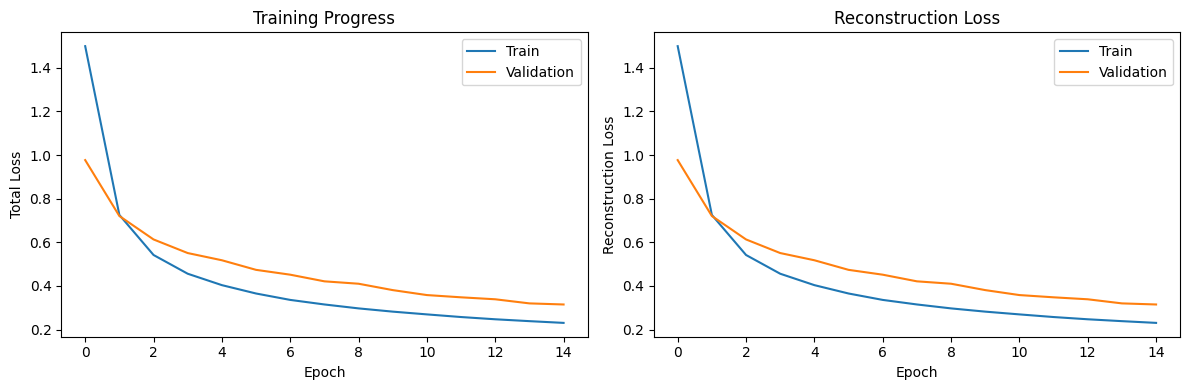


TRAINING COMPLETE!
Best model saved to: /kaggle/working/checkpoints/best_model.pth


In [14]:
if __name__ == "__main__":
    
    print("="*70)
    print("VOICE CONVERSION TRAINING - VCTK CORPUS")
    print("="*70)
    
    # Initialize configuration
    config = Config()
    
    # Option 1: Train from scratch
    print("\n[1] Training new model...")
    model, history = train_model(config)
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.legend()
    plt.title('Training Progress')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_recon'], label='Train')
    plt.plot(history['val_recon'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Reconstruction Loss')
    plt.legend()
    plt.title('Reconstruction Loss')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    print("\n" + "="*70)
    print("TRAINING COMPLETE!")
    print(f"Best model saved to: {config.checkpoint_dir}/best_model.pth")
    print("="*70)
    
  

### 12. Voice Conversion and Audio Reconstruction

This utility performs **end-to-end voice conversion with playback support**, allowing you to directly generate and save the converted audio waveform.

**Pipeline overview:**
1. **Load and resample** the input waveform to the configured sample rate.  
2. **Extract log-scaled mel-spectrograms** for model input.  
3. **Run the trained model** to generate a converted mel-spectrogram conditioned on the target speaker embedding.  
4. **Reconstruct the waveform** using:
   - `InverseMelScale` to map mel features back to a linear spectrogram.
   - `Griffin-Lim` algorithm to estimate the phase and synthesize the time-domain waveform.  
5. **Save the converted audio** to the specified path and return both original and converted waveforms for playback or evaluation.

**Usage Example:**
```python
source_wav, converted_wav = convert_audio_with_playback(
    model,
    source_audio_path="/kaggle/input/sample.wav",
    target_speaker_idx=torch.tensor([5]).to(device),
    config=config,
    save_path="/kaggle/working/converted_sample.wav"
)


In [27]:
import torchaudio
import torch
import torchaudio.transforms as T

def convert_audio_with_playback(model, source_audio_path, target_speaker_idx, config, save_path):
    """Convert a single WAV file to target speaker and return (source_wav, converted_wav)."""
    device = next(model.parameters()).device  # model device
    
    # 1️⃣ Load and resample
    source_wav, sr = torchaudio.load(source_audio_path)
    if sr != config.sample_rate:
        source_wav = torchaudio.functional.resample(source_wav, sr, config.sample_rate)

    # 2️⃣ Convert waveform → mel
    mel_transform = T.MelSpectrogram(
        sample_rate=config.sample_rate,
        n_fft=config.n_fft,
        hop_length=config.hop_length,
        n_mels=config.n_mels
    )
    mel = mel_transform(source_wav)
    mel = torch.log(mel + 1e-9).transpose(1, 2)
    mel = mel.to(device)

    # 3️⃣ Run model (handle tuple outputs)
    with torch.no_grad():
        output = model(mel, target_speaker_idx)
        if isinstance(output, tuple):
            converted_mel = output[0]
        else:
            converted_mel = output

    # 4️⃣ Convert mel → waveform
    vocoder = T.InverseMelScale(
        n_stft=config.n_fft // 2 + 1, n_mels=config.n_mels
    ).to(device)
    griffin_lim = T.GriffinLim(
        n_fft=config.n_fft, hop_length=config.hop_length
    ).to(device)

    linear_spec = vocoder(torch.exp(converted_mel.transpose(1, 2)))
    converted_wav = griffin_lim(linear_spec)

    # 5️⃣ Save & return
    torchaudio.save(save_path, converted_wav.cpu(), config.sample_rate)
    print(f"✅ Converted file saved at {save_path}")

    return source_wav.cpu(), converted_wav.cpu()


### 13. Inference, Playback, and Visualization

This section demonstrates the **complete voice conversion inference pipeline**, including loading the trained model, performing multi-speaker conversion, visualizing mel-spectrograms, and listening to the converted outputs directly within the notebook.

**Steps:**
1. **Model Loading:**  
   - Loads the trained model from the best checkpoint (`best_model.pth`).  
   - Restores the configuration, epoch information, and speaker list.  

2. **Source Audio Selection:**  
   - Randomly selects a sample audio from the VCTK dataset as the source speaker input.  
   - Displays and plays the original waveform for auditory reference.

3. **Voice Conversion:**  
   - Converts the same input audio to multiple target speakers (example IDs: 5, 10, 15).  
   - Uses the trained model to generate converted mel-spectrograms and reconstruct corresponding audio waveforms.  
   - Each converted result is saved as a `.wav` file under `/kaggle/working/`.

4. **Visualization and Playback:**  
   - Displays **side-by-side mel-spectrograms** comparing original and converted speech.  
   - Plays converted audio clips inline using IPython’s `Audio()` for direct qualitative evaluation.

**Output includes:**
- Original and converted **mel-spectrogram plots**.  
- **Playable audio previews** for both source and converted voices.  
- Converted `.wav` files saved locally for download and further inspection.



[2] Loading trained model for inference...
✓ Model loaded from epoch 14
✓ Validation loss: 0.3152
✓ Available speakers: 88

Speaker IDs: ['p225', 'p226', 'p227', 'p228', 'p229', 'p230', 'p231', 'p232', 'p233', 'p234']... (showing first 10)

📂 Source audio: /kaggle/input/english-multispeaker-corpus-for-voice-cloning/VCTK-Corpus/VCTK-Corpus/wav48/p225/p225_019.wav
🎤 Source speaker: p225

🔊 ORIGINAL AUDIO (Source Speaker)



🎙️  CONVERSION 1: Converting to speaker p230 (ID: 5)
✅ Converted file saved at /kaggle/working/converted_p230.wav


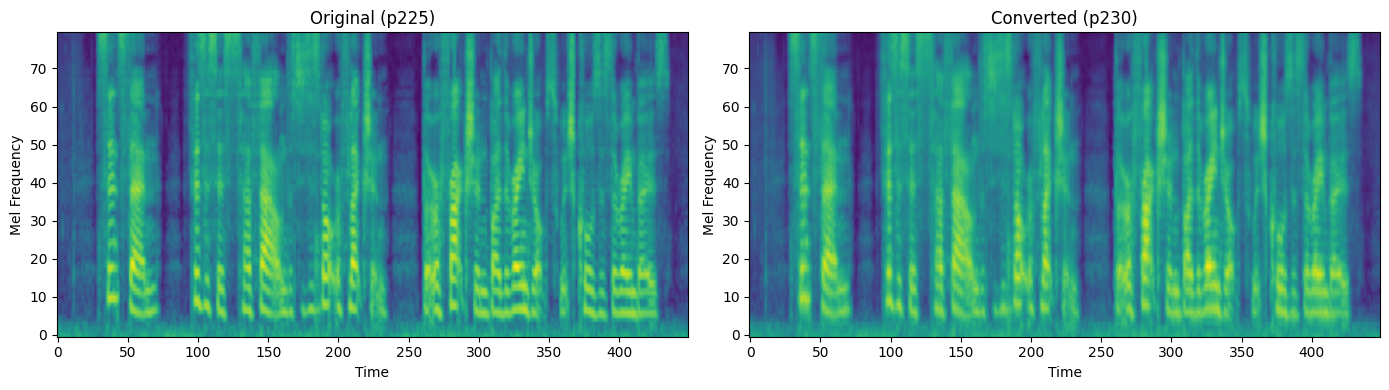

🔊 CONVERTED AUDIO (Target Speaker: p230)


✓ Conversion complete! Saved to: /kaggle/working/converted_p230.wav


🎙️  CONVERSION 2: Converting to speaker p236 (ID: 10)
✅ Converted file saved at /kaggle/working/converted_p236.wav


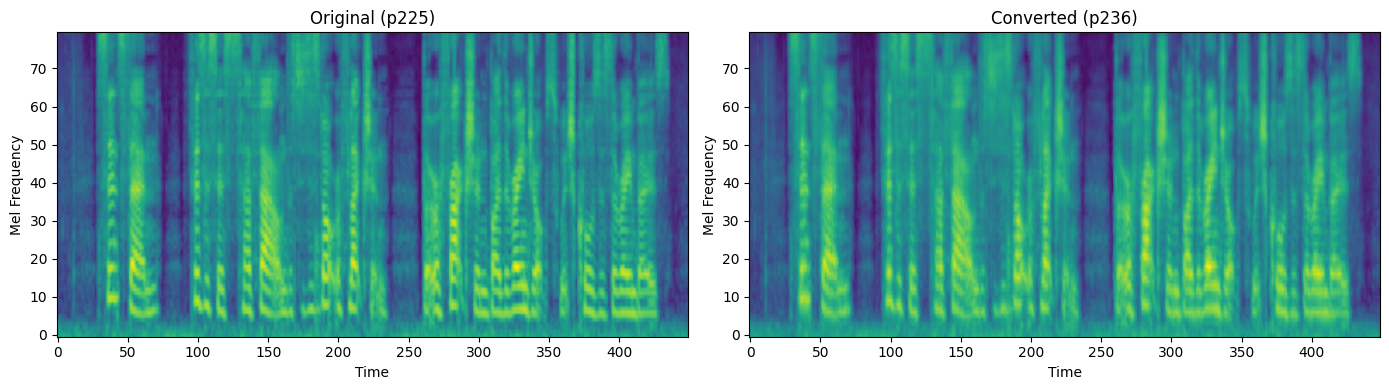

🔊 CONVERTED AUDIO (Target Speaker: p236)


✓ Conversion complete! Saved to: /kaggle/working/converted_p236.wav


🎙️  CONVERSION 3: Converting to speaker p241 (ID: 15)
✅ Converted file saved at /kaggle/working/converted_p241.wav


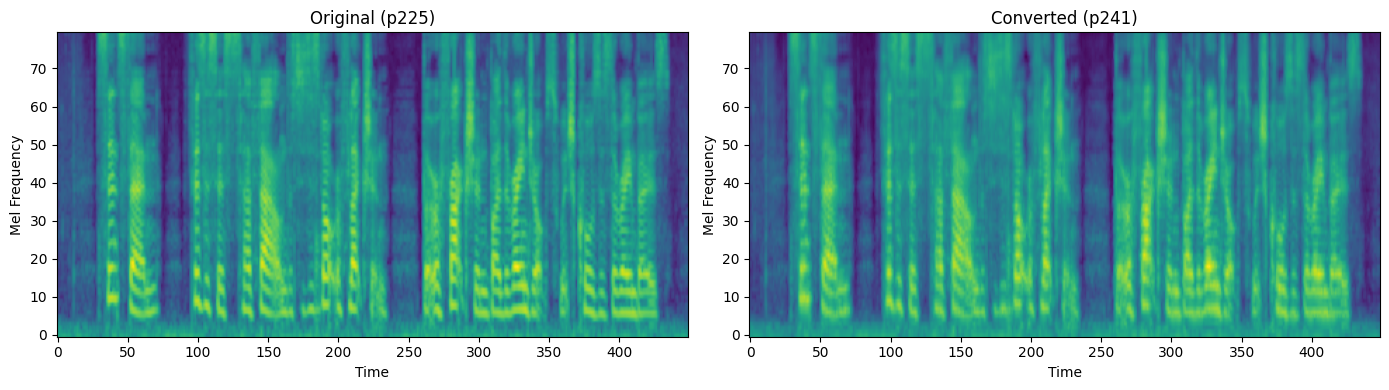

🔊 CONVERTED AUDIO (Target Speaker: p241)


✓ Conversion complete! Saved to: /kaggle/working/converted_p241.wav


✨ ALL CONVERSIONS COMPLETE!

You can now:
1. Listen to original vs converted audio above
2. Compare the mel-spectrograms visually
3. Download converted files from /kaggle/working/


In [28]:
from IPython.display import Audio, display
import IPython.display as ipd
from pathlib import Path
import torch
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import os

print("\n[2] Loading trained model for inference...")

# ✅ Ensure checkpoint path is correct
checkpoint_path = "/kaggle/working/checkpoints/best_model.pth"

if os.path.exists(checkpoint_path):
    # ✅ Fix: Allow full unpickling (PyTorch ≥ 2.6 changed default to weights_only=True)
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

    speakers = checkpoint['speakers']
    num_speakers = len(speakers)

    # Initialize and load model
    model = VoiceConversionModel(config, num_speakers).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print(f"✓ Model loaded from epoch {checkpoint['epoch']}")
    print(f"✓ Validation loss: {checkpoint['val_loss']:.4f}")
    print(f"✓ Available speakers: {num_speakers}")
    print(f"\nSpeaker IDs: {speakers[:10]}... (showing first 10)")

    # Pick a random source audio from VCTK dataset for testing
    test_speaker = speakers[0]  # Use first speaker as source
    audio_dir = Path(config.data_path) / "wav48" / test_speaker
    if not audio_dir.exists():
        audio_dir = Path(config.data_path) / test_speaker

    source_files = list(audio_dir.glob("*.wav"))
    if source_files:
        source_audio = str(source_files[0])
        print(f"\n📂 Source audio: {source_audio}")
        print(f"🎤 Source speaker: {test_speaker}")

        # Play original audio
        print("\n" + "="*60)
        print("🔊 ORIGINAL AUDIO (Source Speaker)")
        print("="*60)
        display(Audio(source_audio))

        # Convert to different speakers
        target_speakers = [5, 10, 15]  # Try converting to multiple speakers

        for idx, target_idx in enumerate(target_speakers):
            if target_idx < num_speakers:
                print(f"\n" + "="*60)
                print(f"🎙️  CONVERSION {idx+1}: Converting to speaker {speakers[target_idx]} (ID: {target_idx})")
                print("="*60)

                # Convert with audio output
                save_path = f"/kaggle/working/converted_{speakers[target_idx]}.wav"
                source_wav, converted_wav = convert_audio_with_playback(
                    model, source_audio, target_idx, config, save_path
                )

                # Visualize mel-spectrograms side by side
                fig, axes = plt.subplots(1, 2, figsize=(14, 4))

                # Original
                mel_transform = T.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=config.n_fft,
                    hop_length=config.hop_length,
                    n_mels=config.n_mels
                )
                original_mel = mel_transform(source_wav)
                original_mel = torch.log(original_mel + 1e-9)

                axes[0].imshow(original_mel.squeeze().numpy(), aspect='auto', 
                              origin='lower', cmap='viridis')
                axes[0].set_title(f'Original ({test_speaker})')
                axes[0].set_xlabel('Time')
                axes[0].set_ylabel('Mel Frequency')

                # Converted
                converted_mel = mel_transform(converted_wav)
                converted_mel = torch.log(converted_mel + 1e-9)

                axes[1].imshow(converted_mel.squeeze().numpy(), aspect='auto', 
                              origin='lower', cmap='viridis')
                axes[1].set_title(f'Converted ({speakers[target_idx]})')
                axes[1].set_xlabel('Time')
                axes[1].set_ylabel('Mel Frequency')

                plt.tight_layout()
                plt.show()

                # Play converted audio
                print(f"🔊 CONVERTED AUDIO (Target Speaker: {speakers[target_idx]})")
                display(Audio(converted_wav.numpy(), rate=config.sample_rate))

                print(f"✓ Conversion complete! Saved to: {save_path}")
                print()

        print("\n" + "="*60)
        print("✨ ALL CONVERSIONS COMPLETE!")
        print("="*60)
        print("\nYou can now:")
        print("1. Listen to original vs converted audio above")
        print("2. Compare the mel-spectrograms visually")
        print("3. Download converted files from /kaggle/working/")

    else:
        print("❌ No audio files found for testing")
else:
    print(f"❌ Checkpoint not found at {checkpoint_path}")
